In [1]:
import pandas as pd

# Load your labeled dataset
df = pd.read_csv("faulty_crop_dataset_labeled.csv")

df.head()

,District_Name,Soil_color,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop,Fertilizer,Link,Label
0,Kolhapur,Black,75.0,50.0,100.000000,6.5,1000.000000,20.0,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo,0
1,Kolhapur,Black,80.0,50.0,115.942557,6.5,828.899424,20.0,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo,0
2,Kolhapur,Black,85.0,50.0,100.000000,6.5,1000.000000,20.0,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo,0
3,Kolhapur,Black,90.0,50.0,100.000000,6.5,1000.000000,20.0,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo,0
4,Kolhapur,Black,95.0,50.0,100.000000,6.5,1000.000000,20.0,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo,0


In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Step 1: Separate features and target
X = df.drop(columns=["Label", "Link"])  # Drop target + any irrelevant columns
y = df["Label"]  # This should be 0 (Normal) or 1 (Faulty)

# Step 2: Encode categorical features
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Step 3: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape after scaling:", X_scaled.shape)


Shape after scaling: (4513, 10)


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 2: Define the PNN class
class PNN:
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.classes = np.unique(y)

    def _kernel(self, x, X_cls):
        diffs = X_cls - x
        dists_sq = np.sum(diffs ** 2, axis=1)
        return np.exp(-dists_sq / (2 * self.sigma ** 2))

    def predict(self, X):
        X = np.array(X)
        y_pred = []
        for x in X:
            probs = []
            for cls in self.classes:
                X_cls = self.X_train[self.y_train == cls]
                kernels = self._kernel(x, X_cls)
                prob = np.sum(kernels)
                probs.append(prob)
            y_pred.append(self.classes[np.argmax(probs)])
        return np.array(y_pred)

In [4]:
# Step 3: Train and predict

Sigma: 0.001 → Accuracy: 0.4563 | Normal: 903, Faulty: 0
Sigma: 0.002 → Accuracy: 0.4563 | Normal: 903, Faulty: 0
Sigma: 0.005 → Accuracy: 0.6290 | Normal: 747, Faulty: 156
Sigma: 0.010 → Accuracy: 0.6766 | Normal: 702, Faulty: 201
Sigma: 0.020 → Accuracy: 0.6910 | Normal: 683, Faulty: 220
Sigma: 0.050 → Accuracy: 0.7054 | Normal: 666, Faulty: 237
Sigma: 0.100 → Accuracy: 0.8018 | Normal: 579, Faulty: 324
Sigma: 0.200 → Accuracy: 0.9568 | Normal: 437, Faulty: 466
Sigma: 0.500 → Accuracy: 0.9203 | Normal: 456, Faulty: 447


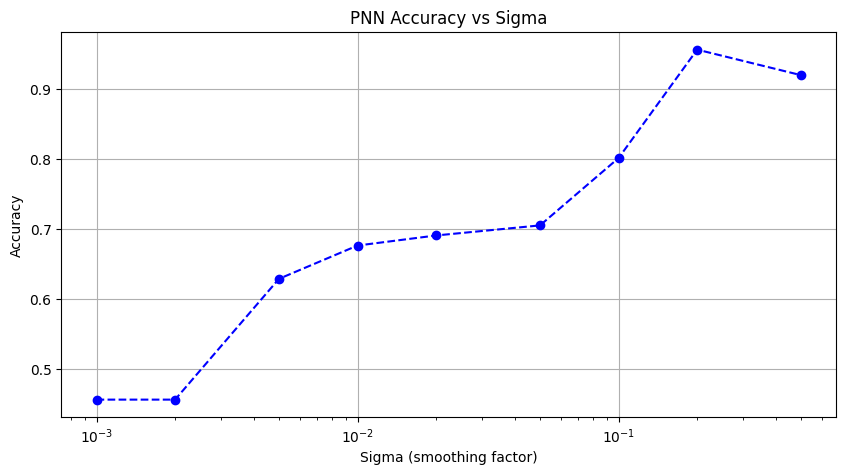

In [5]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

sigmas = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
accuracies = []
normal_counts = []
faulty_counts = []

for sigma in sigmas:
    pnn = PNN(sigma=sigma)
    pnn.fit(X_train, y_train)
    y_pred = pnn.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # Count predictions
    unique, counts = np.unique(y_pred, return_counts=True)
    class_count = dict(zip(unique, counts))
    normal_counts.append(class_count.get(0, 0))
    faulty_counts.append(class_count.get(1, 0))

    print(f"Sigma: {sigma:.3f} → Accuracy: {acc:.4f} | Normal: {class_count.get(0,0)}, Faulty: {class_count.get(1,0)}")

# --- Plot Accuracy vs Sigma ---
plt.figure(figsize=(10, 5))
plt.plot(sigmas, accuracies, marker='o', linestyle='--', color='blue')
plt.xlabel("Sigma (smoothing factor)")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.grid(True)
plt.show()

In [6]:
# Step 1: Retrain PNN on full dataset
final_pnn = PNN(sigma=0.2)
final_pnn.fit(X_scaled, y)

# Step 2: Predict on full dataset (ordered sequence)
full_preds = final_pnn.predict(X_scaled)

# Step 3: Convert predictions to binary sequence (0=Normal, 1=Faulty)
sequence_binary = np.array(full_preds)

# Preview the result
print("Sequence preview (first 50):", sequence_binary[:50])
print(f"Total Normal: {(sequence_binary==0).sum()} | Total Faulty: {(sequence_binary==1).sum()}")

Sequence preview (first 50): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0]
Total Normal: 2531 | Total Faulty: 1982


In [7]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Converged: True
Iterations: 42


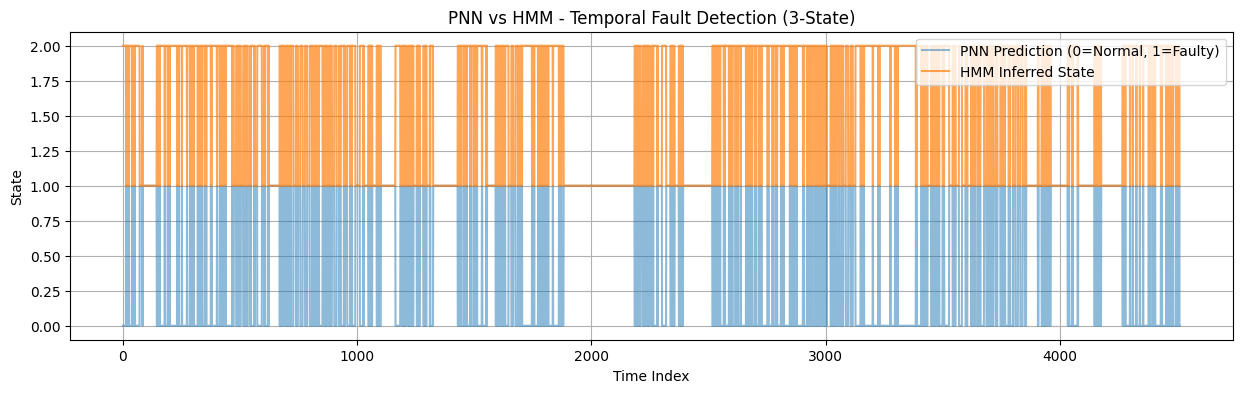

State Analysis:
            %Faulty  Occurrences
HMM_State                      
1              1.0         1982
2              0.0         2531

 Assigned State Labels: {1: 'Permanent Fault', 2: 'Normal'}


In [8]:
from hmmlearn import hmm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 1: Reshape for HMM input (must be 2D)
sequence_reshaped = sequence_binary.reshape(-1, 1)

# Step 2: Define and train 3-state HMM
model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100, random_state=42)
model.fit(sequence_reshaped)
print("Converged:", model.monitor_.converged)
print("Iterations:", model.monitor_.iter)

# Step 3: Predict hidden states
hidden_states = model.predict(sequence_reshaped)

# Step 4: Visualize
plt.figure(figsize=(15, 4))
plt.plot(sequence_binary, label="PNN Prediction (0=Normal, 1=Faulty)", alpha=0.5)
plt.plot(hidden_states, label="HMM Inferred State", alpha=0.7)
plt.legend()
plt.title("PNN vs HMM - Temporal Fault Detection (3-State)")
plt.xlabel("Time Index")
plt.ylabel("State")
plt.grid(True)
plt.show()

# Step 5: Analyze state-to-fault mapping
df_hmm = pd.DataFrame({
    "HMM_State": hidden_states,
    "PNN_Output": sequence_binary
})

state_summary = df_hmm.groupby("HMM_State")["PNN_Output"].agg(["mean", "count"])
state_summary.columns = ["%Faulty", "Occurrences"]
print("State Analysis:\n", state_summary)

# Step 6: Assign meaning to states based on %Faulty
state_labels = {}
for state in state_summary.index:
    fault_ratio = state_summary.loc[state, "%Faulty"]
    if fault_ratio > 0.8:
        state_labels[state] = "Permanent Fault"
    elif fault_ratio > 0.2:
        state_labels[state] = "Intermittent  Fault"
    else:
        state_labels[state] = "Normal"


print("\n Assigned State Labels:", state_labels)


In [9]:
# Evaluation: Accuracy and Metrics

In [19]:
state_labels = {1: 'Permanent Fault', 2: 'Normal'}
# Converting state meanings to binary fault predictions
fault_mapping = {'Permanent Fault': 1, 'Normal': 0}
predicted_faults = [fault_mapping[state_labels[state]] for state in hidden_states]
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure same length
true_labels = df["Label"].values

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_faults)
print("\nConfusion Matrix:\n", cm)

# Classification Report
report = classification_report(true_labels, predicted_faults, target_names=["Normal", "Faulty"])
print("\n Classification Report:\n", report)

# Accuracy
acc = accuracy_score(true_labels, predicted_faults)
print(f"\n Accuracy results after fault detection: {acc:.4f}")


Confusion Matrix:
 [[2528    6]
 [   3 1976]]

 Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2534
      Faulty       1.00      1.00      1.00      1979

    accuracy                           1.00      4513
   macro avg       1.00      1.00      1.00      4513
weighted avg       1.00      1.00      1.00      4513


 Accuracy results after fault detection: 0.9980
